___
# <center><a>Q-Learning<a/>
___

In [1]:
import tqdm
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from tqdm import trange

plt.style.use('ggplot')

___
## <center><a>Среда<a/>
___

Obseravtion space: Discrete(500)
Action space: Discrete(6)


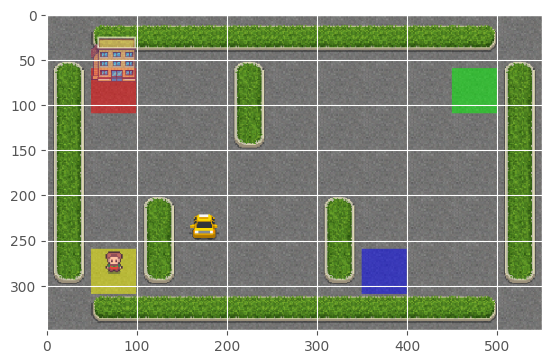

In [9]:
env = gym.make("Taxi-v3", render_mode="rgb_array")
env.reset()
state_n = env.observation_space.n
act_n = env.action_space.n

print(f"Obseravtion space: {env.observation_space}")
print(f"Action space: {env.action_space}")
plt.imshow(env.render());

___
## <center><a>Политика<a/>
___

- Таблица Q-значений [состояние, действие]

In [3]:
def get_qtable(env) -> np.ndarray:
    state_n = env.observation_space.n
    act_n = env.action_space.n
    qtable = np.zeros((state_n, act_n))
    return qtable

qtable = get_qtable(env)

- Действие с `максимальноым` Q-значением для текущего состояния

In [4]:
def get_max_value_action(qtable: np.ndarray, state: int) -> int:
    action = int(np.argmax(qtable[state, :]))
    return action

get_max_value_action(qtable, 2)

0

- Случайное действие для `исследования`

In [5]:
def get_random_action(env) -> int:
    action = int(env.action_space.sample())
    return action

get_random_action(env)

1

- `Epsilon-жадная` политика

In [6]:
def get_policy_action(env, qtable: np.ndarray, state: int, eps: float) -> int:
    if np.random.uniform(0, 1) > eps:
        action = get_max_value_action(qtable, state)
    else:
        action = get_random_action(env)
    return action

get_policy_action(env, qtable, 1, 0.1)

0

___
## <center><a>Обучение<a/>
___

- $ \epsilon\in (0, 1)$ : max -> min 
    - Исследование -> Эксплуатация
- $Q(s_k, a_k) \leftarrow Q(s_k, a_k) + \alpha \cdot (r_k + \gamma \cdot max(Q(s_{k+1}, a_{k+1})) - Q(s_k, a_k))$

Episodes: 100%|██████████| 5000/5000 [00:07<00:00, 701.92it/s] 


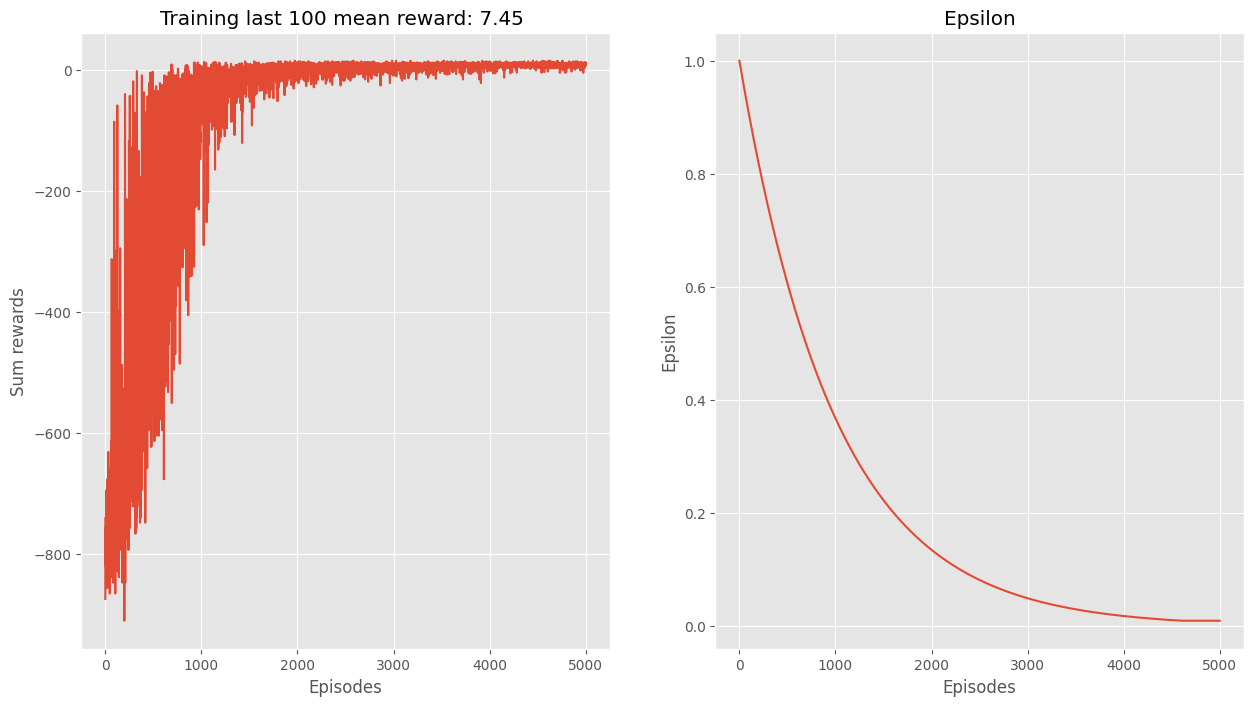

In [7]:
def train_algo(env, episodes_n, max_steps, eps_min, eps_decay, lr, gamma, reward_calc_n: int = 100):
    qtable = get_qtable(env)
    total_episodes_rewards = []
    total_eps = []
    for episode in trange(episodes_n, desc='Episodes'):
        eps = max(eps_min, 1 * (eps_decay**episode))
        state, _ = env.reset()

        episode_reward = 0
        for step in range(max_steps):
            action = get_policy_action(env, qtable, state, eps)
            next_state, reward, terminated, truncated, info = env.step(action)
            qtable[state][action] = qtable[state][action] + lr * (reward + gamma * np.max(qtable[next_state]) - qtable[state][action])
            episode_reward += reward

            if truncated or terminated:
                break
            state = next_state
        total_episodes_rewards.append(episode_reward)
        total_eps.append(eps)

    sum_reward = np.sum(total_episodes_rewards[-reward_calc_n:])
    mean_reward = np.mean(total_episodes_rewards[-reward_calc_n:])

    f, ax = plt.subplots(1,2, figsize=(15,8))
    ax[0].plot(total_episodes_rewards)
    ax[0].set_xlabel('Episodes')
    ax[0].set_ylabel('Sum rewards')
    ax[0].set_title(f"Training last {reward_calc_n} mean reward: {mean_reward} ")

    ax[1].plot(total_eps)
    ax[1].set_xlabel('Episodes')
    ax[1].set_ylabel('Epsilon')
    ax[1].set_title(f"Epsilon")

    return qtable, mean_reward, sum_reward, total_episodes_rewards

trained_qtable, mean_reward, sum_reward, total_episodes_rewards = train_algo(
    env=env,
    episodes_n=5000,
    max_steps=200,
    eps_min=0.01,
    eps_decay=0.999,
    lr=0.1,
    gamma=0.99)

___
## <center><a>Оценка алгоритма<a/>
___
- Выбор действий с `максимальным Q-значениями` (эксплуатация)

Episodes: 100%|██████████| 300/300 [00:00<00:00, 5453.83it/s]


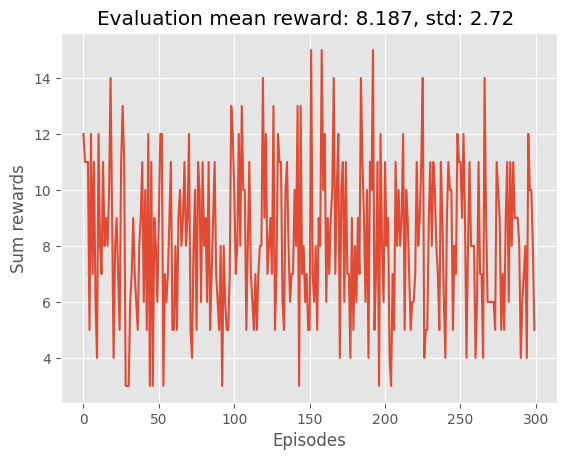

In [8]:
def evaluate_algo(env, episodes_n, max_steps, qtable):
    env.reset(seed=1)
    total_episodes_rewards = []
    for episode in trange(episodes_n, desc='Episodes'):
        state, _ = env.reset()
        episode_reward = 0
        for step in range(max_steps):
            action = get_max_value_action(qtable, state)
            next_state, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            if truncated or terminated:
                break
            state = next_state
        total_episodes_rewards.append(episode_reward)
    std_reward = np.std(total_episodes_rewards)
    mean_reward = np.mean(total_episodes_rewards)
    plt.plot(total_episodes_rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Sum rewards')
    plt.title(f"Evaluation mean reward: {mean_reward:.3f}, std: {std_reward:.2f} ")

    return mean_reward, sum_reward

mean_reward, sum_reward = evaluate_algo(
    env=env,
    episodes_n=300,
    max_steps=200,
    qtable=trained_qtable)